<button data-commandLinker-command="progressivis:cleanup_and_run" data-commandlinker-args='{"index": 1}' href="#" class='progressivis-cleanup-and-run-btn'>Run ProgressiVis</button>

In [1]:
from ipyprogressivis.widgets.chaining.constructor import Constructor
from ipyprogressivis.widgets.chaining.utils import create_root, get_header
from ipyprogressivis.widgets.chaining.custom import *
header = get_header()
display(header.talker)
display(header.backup)
_ = header.constructor
with header.modules_out:
    display(header.board)
with header.widgets_out:
    display(header.manager)
header.talker.labcommand("notebook:hide-cell-code")
%reload_ext ipyprogressivis.magics
create_root(header.backup)

## root
This scenario uses two CSV data sources:
* a dataset with NYC Taxi trips in January 2015
* a second dataset of NYC weather data for the same period
<pre></pre>
The aim is to produce a line chart enabling us to progressively observe the possible relationship between cab activity and precipitation levels.
After starting ProgressiVis, create a CSV loader for weather data as follows:
* Select "CSV loader" in Loader list
* Enter the alias "Weather"
* press "Create"


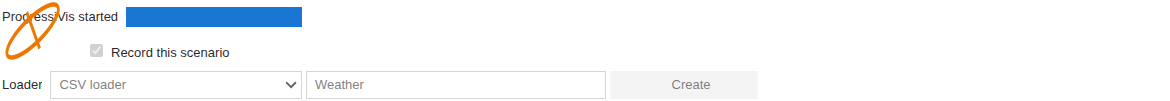

Starting scheduler
# Scheduler added module(s): ['sink_1', 'variable_1']


In [2]:
# do not run this cell
display(header.constructor)
header.constructor.start_scheduler()
header.talker.labcommand('notebook:hide-cell-code')

## Weather
In order to create the loader for the weather data you have to:
* Enter and "sniff" the CSV file this way:
  * If the URL `https://www.aviz.fr/nyc-taxi/nyc_weather_2015.csv` is present in the `Bookmarks` list, select it, otherwise copy ans paste it in the `New URLs` field.
  * Open the sniffer by pressing `Sniff`
  * Uncheck `Enable/disable all` checkbox
* Select and configure the necessary columns:
  * `Date` column:
    * Select `Date` from the `PColumn` list. Details are then displayed then in the `SelectedPColumn` frame
    * check the `Use` checkbox. The other fields in the frame are then unlocked
    * select `datetime`  in the `Retype` select list
  * `PrecipitationIn` column
    * Select `PrecipitationIn` in the `PColumn` list. Details are displayed.
    * check the `Use` checkbox. The other fields in the frame appear.
    * select `float64`  in the `Retype` select list
    * check the "NA values" checkbox. In the field with the same name, enter "T".
### Explanation
The `PrecipitationIn` column contains numerical values except for cells containing the letter "T" which stands for `trace precipitation amount or snow depth (an amount too small to measure, usually < 0.005 inches water equivalent) (appears instead of numeric value)` according to the [Local Climatological Data (LCD) Dataset Documentation](https://www.ncei.noaa.gov/pub/data/cdo/documentation/LCD_documentation.pdf).<br/>
With the above transformations, the `PrecipitationIn` column will be of type `float64` and the "T" value will become `NaN`. <br/>
Press `Test` to view a sample of data.<br/>
Select the `Hide` tab to hide the samples.<br/>
At this point, optionally you can save the settings for later. by modifying (or not) the default file name (w202...) then press `Save settings` <br/>
You can start loading with the `Start loading` button.<br/>
To continue building the scenario, we'll need to add a 2nd data source, cab fares.<br/>
<pre></pre>
Select `Next stage`: `CSV loader` and enter the name `Taxis` as optional alias, then press `Chain it`.


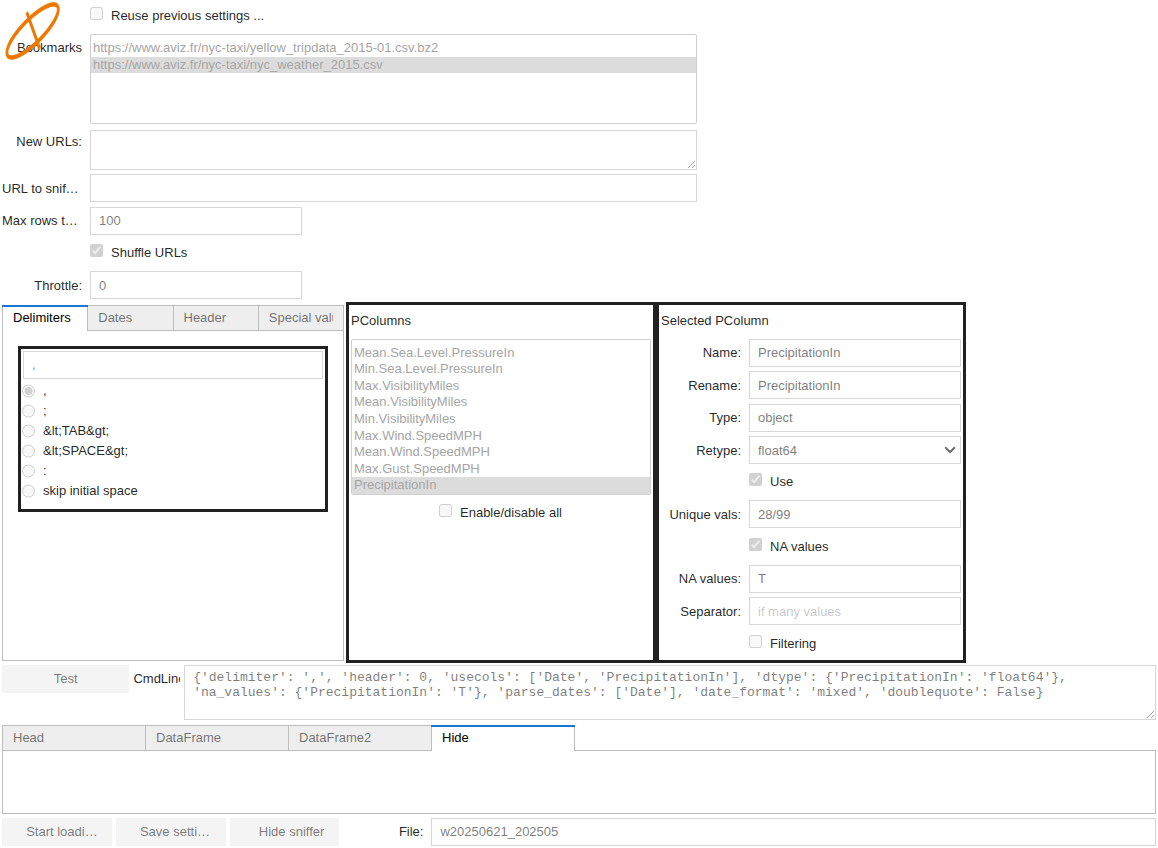

In [3]:
Constructor.widget('Weather', 0)

## Taxis
Like above:
* If the URL ` https://www.aviz.fr/nyc-taxi/yellow_tripdata_2015-01.csv.bz2` is present in the `Bookmarks` list, select it, otherwise copy and paste it in the `New URLs` field.
* Open the sniffer by pressing `Sniff`
* Uncheck `Enable/disable all` checkbox
* Select `tpep_pickup_datetime` from the `PColumn` list (the single column needed here).
* check the `Use` checkbox.
* select `datetime`  in the `Retype` select list
<pre></pre>
Optionally save settings for later use as above.<br/>
Now we're going to join the two data sources we've already created.
<pre></pre>
Select `Next stage`: `Join` then press `Chain it`


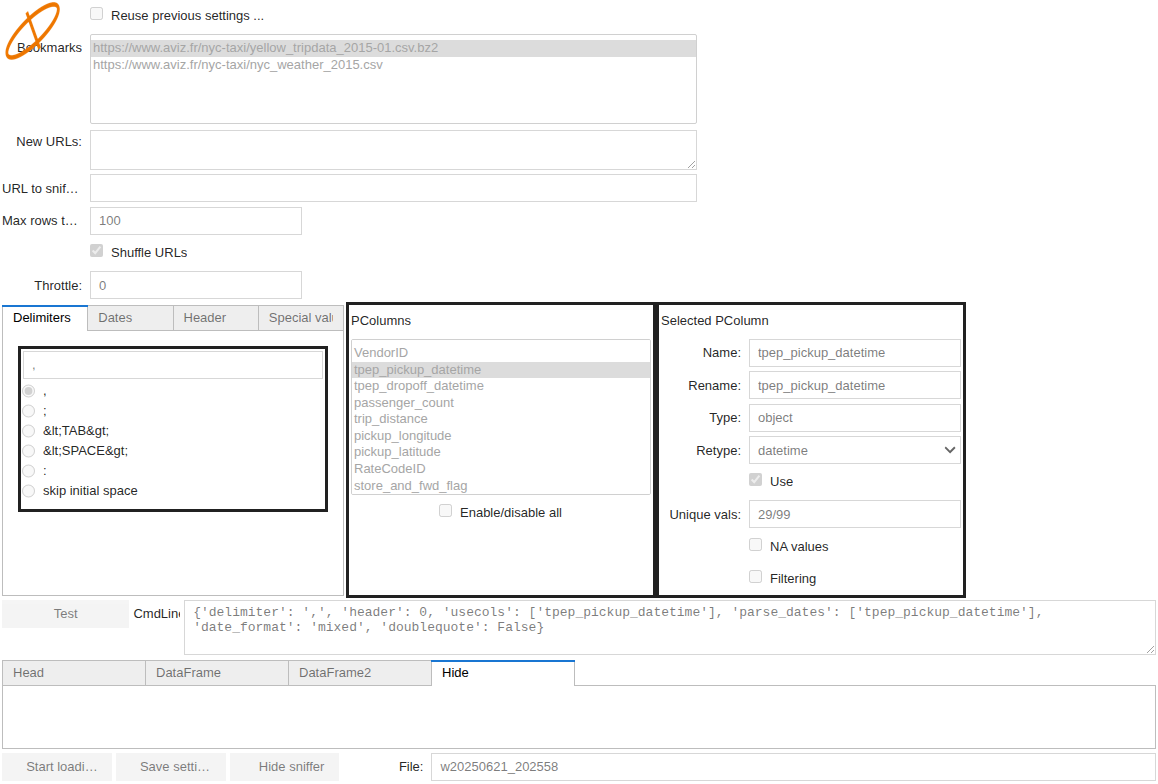

In [4]:
Constructor.widget('Taxis', 0)

## Join
`ProgressiVis` currently only implements `1 to N` joins (covering the particular case of `1 to 1` joins).
<pre></pre>
In addition, `ProgressiVis` represents the `datetime` type as a row vector of size 6 of the form `YMDhms`.
<pre></pre>
This allows a join to be made on part of two `datetime` columns, for example on the `YMD` elements.
<pre></pre>
In the current case, the `Weather` table contains one row per day (so the `Date` column will be of the form `[Y, M, D, 0, 0, 0]`), while the `Taxis` table contains one row per trip, with the `tpep_pickup_datetime` column having all 6 `YMDhms` elements fully populated.
<pre></pre>
By making a join between the two tables on the `YMD` subcolumns of the two columns mentioned, we'll associate all the races of a day with the corresponding weather line.
<pre></pre>
The join will be an "inner join", as orphan elements in one of the two tables, if they exist, are of no interest for our scenario.
<pre></pre>
In the interface, we call the table corresponding to part "1" in the "1 to N" relationship "Primary Table" and the table corresponding to part "N" "Relative Table".
<pre></pre>
In concrete terms, in our case, the `Weather` table will be **primary** and the `Taxis` table will be **relative**.
<pre></pre>
In the first frame, on the left (Inputs) select the 2nd table to be joined (`Weather`) and on the right assign the roles (`Weather` => `Primary`, `Taxis` => `Related`) and confirm with the "OK" button.
<pre></pre>
In the next frame, we'll define the join that will be performed on the `YMD` subcolumns of the `Weather.Date` and `Taxis.tpep_pickup_datetime` columns.
<pre></pre>
The checkboxes in the "Keep" column can be used to exclude certain unnecessary columns from the join (but we don't need them here).
<pre></pre>
Keep the default value `How`: `inner`and press `Start`


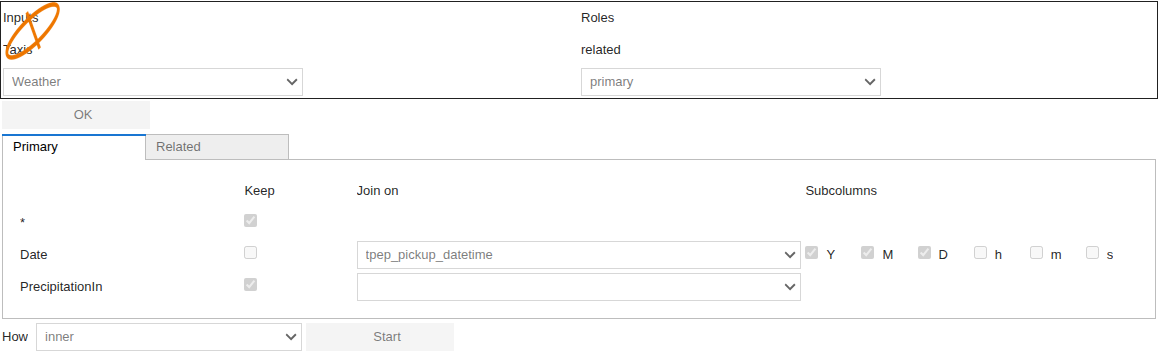

In [5]:
Constructor.widget('Join', 0)

In [6]:
# progressivis-snippets
import numpy as np
@register_function
@np.vectorize
def rain_level(val: float) -> str:
    if np.isnan(val) or val < 0.07:
        return "No"
    if val < 0.19:
        return "Light"
    return "Rain"

## Rich view
Alas, the information contained in the columns of the join is not in a form suited to the intended processing. Fortunately, `ProgressiVis` allows you to create calculated (or virtual) columns in addition to the stored columns of a table.
<pre></pre>
A calculated column is an object that applies a function to one or more columns in the same table and provides the same interface as a stored column.
<pre></pre>
To take this a step further, we're now going to create a join view, which we'll enrich with 3 calculated columns required for further processing.
<pre></pre>
Two of these (`hour()` and `year_day()`) are standard `datetime` functions and are already available in the `ProgressiVis` library.
<pre></pre>
The third (`rain_level()`) is a function specific to our application. It transforms quantitative precipitation data into categorical data ("Rain", "Light" and "No") more suited to the `Line chart` visualization we're planning.
<pre></pre>
But before creating the view, we'll define the `rain_level()` function (see cell above).
<pre></pre>
A few explanations on the coding conventions used in this cell:
* the comment `# progressivis-snippets` on the first line of the cell is important because it tells the `ipyprogressivis` loader that this cell must be reexecuted if the scenario is replayed.
* the `@register_function` decorator registers the function with the various widgets supposed to provide it to the analyst (via a select list, for example)
* the `@vectorize decorator` is part of `numpy` and is described [here](https://numpy.org/doc/stable/reference/generated/numpy.vectorize.html)
<pre></pre>
In this implementation, the precipitation level "T", (converted in `NaN`), will be categorized as "No".
<pre></pre>
To create the computed view, select `Next stage`: `Computed view` with the alias `Rich view` then push `Chain it`.
<pre></pre>
Each computed column is defined by associating a column (the list on the left) and a function (the list in the middle).
<pre></pre>
The calculated column appears on the right. The default name is intended to avoid naming conflicts, but we recommend changing it to a shorter, more expressive name if possible.
<pre></pre>
You can also change the column type if the one proposed is not appropriate.
<pre></pre>
When all is OK, check the `Use` checkbox.
<pre></pre>
The three columns have to be created as follows:
* `tpep_pickup_datetime` + `hour()` => `pickup_hour`
* `tpep_pickup_datetime` + `year_day()` => `pickup_year_day`
* `PrecipitationIn` + `rain_level()` => `rain_level`
<pre></pre>
Among the stored columns to be kept in the view, we keep `PrecipitationIn` (because the view must contain at least one stored columns).
<pre></pre>
When everything is ready, click `Apply`.
<pre></pre>
To move on to the next stage, click `Next stage`: `Group by` then `Chain it`.


# Scheduler added module(s): ['data_shape_1', 'sink_5']


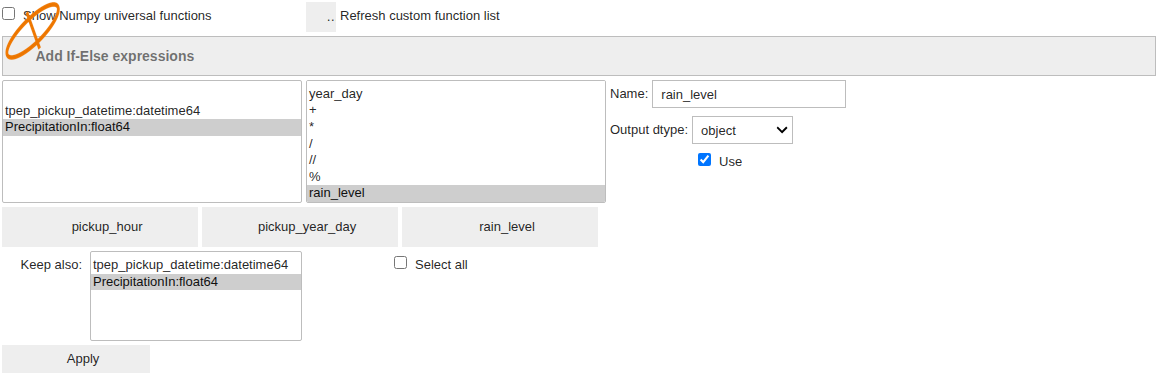

# Scheduler deleted module(s): {'data_shape_1', 'sink_5'}


In [7]:
Constructor.widget('Rich view', 0)

## Group by
This step builds an index to group together the rows produced previously that share the same values for the pair (`pickup_hour`, `rain_level`).
<pre></pre>
This index will be used in the next stage to aggregate the values thus selected.
<pre></pre>
To proceed with aggregation, select `Next stage`: `Aggregate` then `Chain it`.


# Scheduler added module(s): ['data_shape_1', 'sink_6']


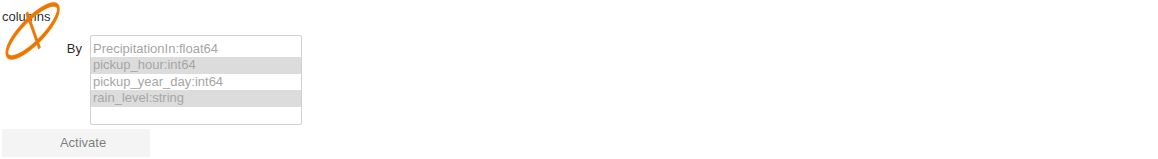

# Scheduler deleted module(s): {'data_shape_1', 'sink_6'}


In [8]:
Constructor.widget('Group by', 0)

## Aggregate
The first row of the table displayed is "ROW" and represents not a column but the entire row of the input table.
<pre></pre>
The only possible operation on rows is their count. We count rows sharing the same pair (`pickup_hour`, `rain_level`), which will produce the `_count` column in the output table.
<pre></pre>
A second necessary aggregation is the `uniq` operation on the `pickup_year_day` column, which will count the distinct values of days sharing the same pair (`pickup_hour`, `rain_level`).
<pre></pre>
The output will be a table containing 24 time intervals * 3 rain levels = 92 rows
<pre></pre>
Before displaying, a normalization step is required. This will be performed via a new computed view.
<pre></pre>
To proceed with normalization, select `Next stage`: `Computed view` with the alias `Norm`, then `Chain it`.


# Scheduler added module(s): ['data_shape_1', 'sink_7']


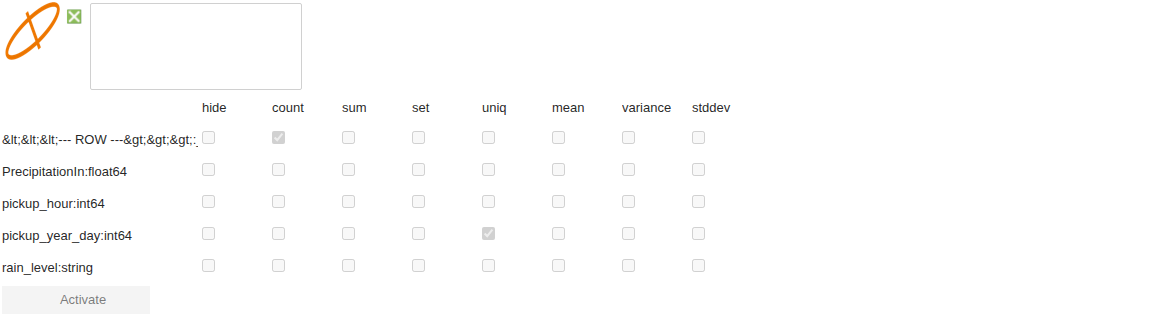

# Scheduler deleted module(s): {'sink_7', 'data_shape_1'}


In [9]:
Constructor.widget('Aggregate', 0)

## Norm
The"_count" column of the aggregation shows the number of pickups performed for each pair (`pickup_hour`, `rain_level`).
<pre></pre>
As it stands, this value cannot be used to measure cab activity, as it depends on the meteorological factor (the number of rainy days etc.).
<pre></pre>
It therefore needs to be normalized by dividing this value (`_count`) by the total number of distinct days in each pair (`pickup_hour`, `rain_level`).
<pre></pre>
In the interface, we now select the two columns `_count` and `pickup_year_day_uniq` and the function `//`. We'll associate each function parameter with a column as follows:
* numerator `num` with column `_count`
* the denominator `den` with the column `pickup_year_day_uniq`.
<pre></pre>
Rename the new column `trips_per_day` and check the `Use` checkbox.
<pre></pre>
We also keep the `pickup_hour` and `rain_level` columns in the result.
<pre></pre>
We now have all the elements we need for display.
<pre></pre>
To do this, select `Next stage`: `Any vega` with the alias `Line chart` then `Chain it`.
<pre></pre>


# Scheduler added module(s): ['data_shape_1', 'sink_8']


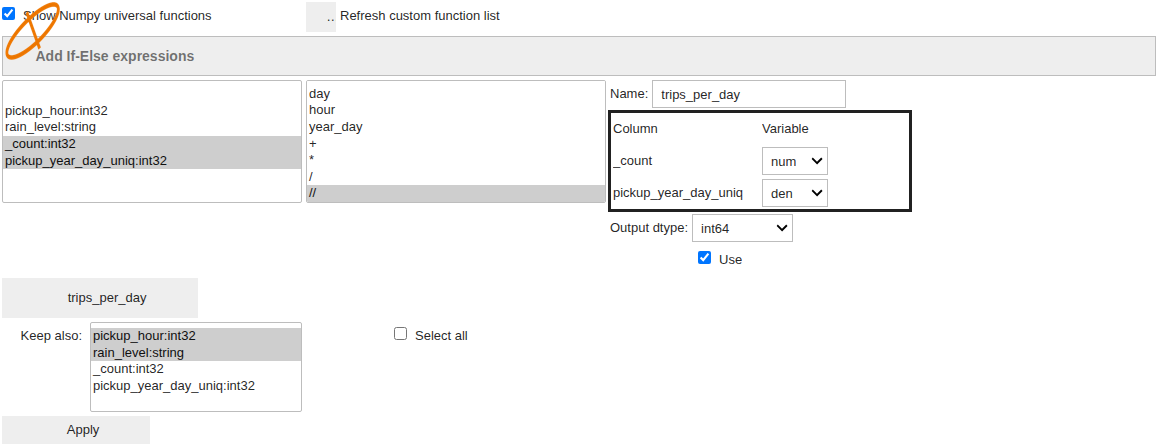

# Scheduler deleted module(s): {'sink_8', 'data_shape_1'}


In [10]:
Constructor.widget('Norm', 0)

## Line chart
If the schema `line_chart.json` is present in the `Schema` list, select it, otherwise you can obtain it [here](https://github.com/progressivis/ipyprogressivis/blob/main/.progressivis/widget_settings/AnyVegaW/line_chart.json) and then copy it directly into the `JSon` editor.
<pre></pre>
Use the `Fetch info` button to extract the names of the fields present in the schema and associate them with the columns of the input table as follows:
* `x` => `pickup_hour`
* `y` => `trips_per_day`
* `color` => `rain_level`<br/>
<pre></pre>
then press `Apply`.


# Scheduler added module(s): ['data_shape_1', 'sink_9']


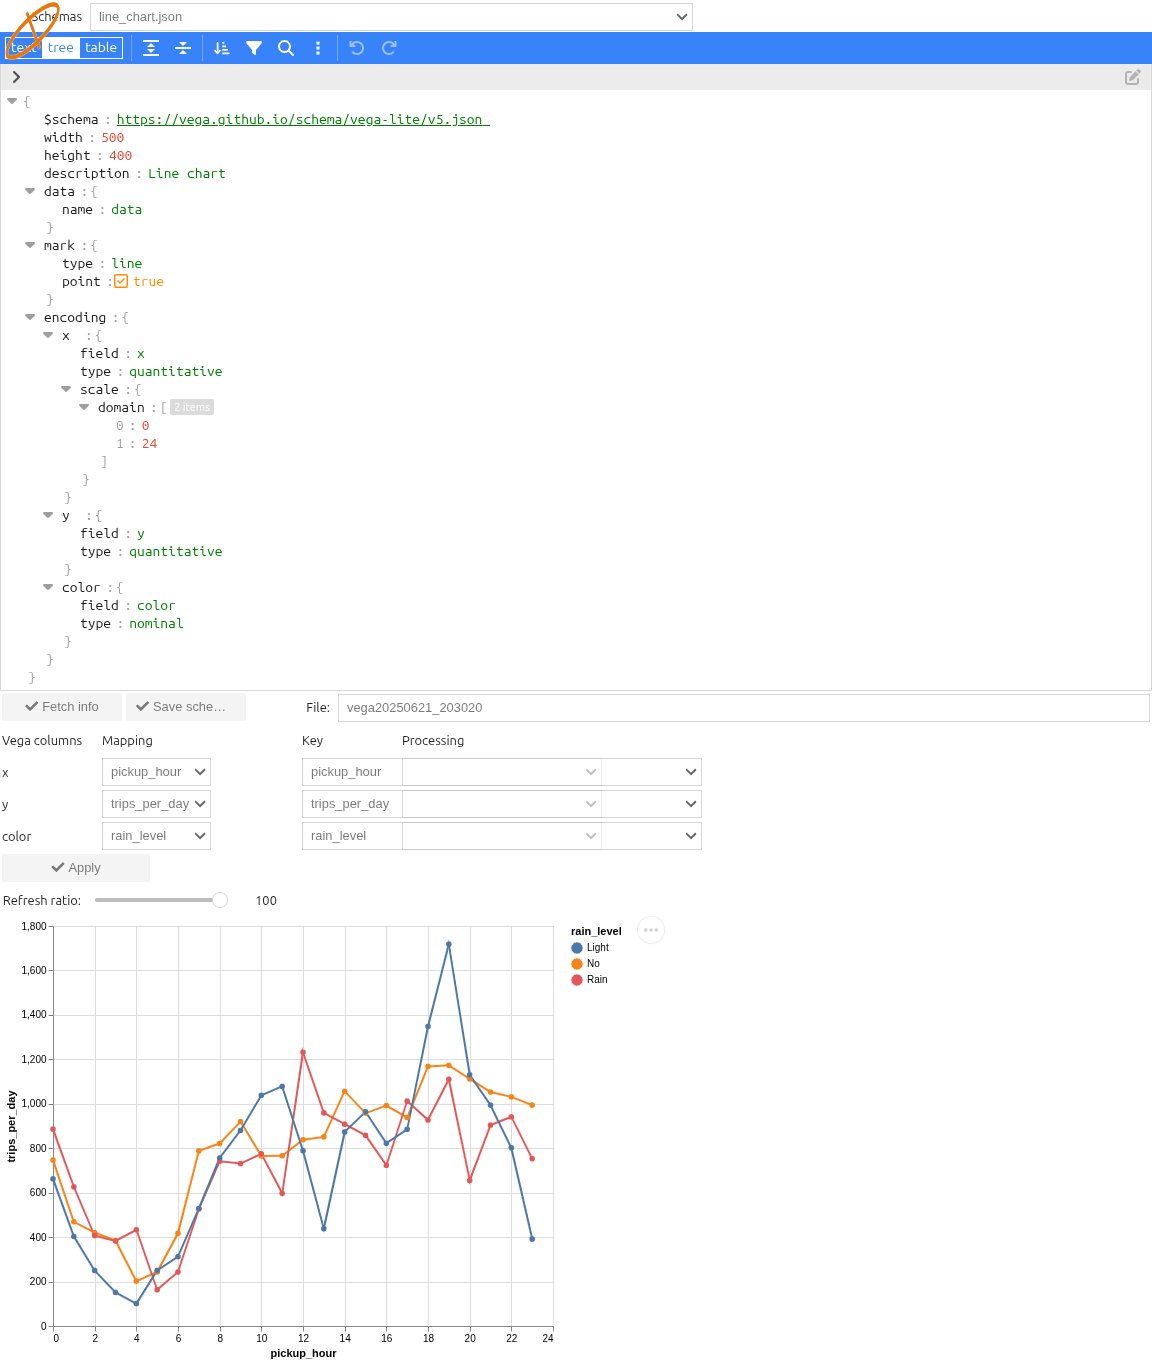

# Scheduler deleted module(s): {'data_shape_1', 'sink_9'}


In [11]:
Constructor.widget('Line chart', 0)